In [1]:
import numpy as np
import numpy.linalg as npl
import numpy.random as npr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Bonnes pratiques en NumPy


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/NumPy_logo_2020.svg/1280px-NumPy_logo_2020.svg.png" width="256px" align="left"/>

Les séances précédentes avaient pour objectifs de vous familiariser avec les différentes librairies formant l'écosystème `python scientifique`.
Nous nous sommes notamment intéresser à la bibliothèque **NumPy**.
Cette dernière fournie toutes les briques de base nécessaires pour le calcul scientifique en `python`, notamment la structure données connue sous le nom de `numpy array`.
**NumPy** fournit également une ensemble de fonctions mathématiques opérant sur ces tableaux.
Bien qu'il s'agisse d'une bibliothèque Python, la plupart de ses fonctions sont écrites dans un langage de plus bas niveau tel que [Fortran](https://fr.m.wikipedia.org/wiki/Fortran) ou [C](https://fr.m.wikipedia.org/wiki/C_(langage)).
L'utilisation de tels langages pour la partie calculatoire permet de garantir d'excellentes performances tandis que l'interface Python simplifie fortement l'utilisation de ces fonctions.

Dans le cadre du présent TP, nous allons maintenant nous intéresser aux bonnes pratiques devant être mises en oeuvre afin de tirer parti au maximum des performances de **NumPy**.
Pour cela, plusieurs bouts de code vous sont présentés ci-dessous.
Pour chacun d'entre eux, votre objectif est non seulement de comprendre ce qu'ils font (une rapide description vous est néanmoins donnée en préambule), mais aussi de les ré-écrire de façon plus efficace (notamment en *vectorisant* ce qui peut être vectorisé).

---

## Méthode des moindres carrés

Le cadre d'application de ce TP sera la [méthode des moindres carrés](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_moindres_carr%C3%A9s).
Cette méthode, développée indépendamment au début du XIXe siècle par le mathématicien français [Adrien-Marie Legendre](https://fr.wikipedia.org/wiki/Adrien-Marie_Legendre) et le mathématicien Allemand [Carl Friedrich Gauss](https://fr.wikipedia.org/wiki/Carl_Friedrich_Gauss) permet de comparer des données expérimentales (généralement entachées d'erreurs de mesure) à un modèle mathématique censé les décrire.
Elle repose sur la formulation d'un problème d'optimisation permettant de trouver la meilleure estimation possible des paramètres de ce modèle.

Afin de limiter la difficulté de ce TP, nous nous limiterons à la méthode dite des *moindres carrés linéaire*.
Etant donné un ensemble de données $(x_i, y_i)$ (où $x_i$ est l'abscisse des points de données et $y_i$ leur ordonnée), on supposera alors que ces données peuvent être décrites par le modèle suivant

$$
y_i \simeq a x_i + b
$$

où $a$ et $b$ sont les paramètres que l'on cherche à déterminer.
La figure ci-dessous illustre le jeu de données avec lequel nous travaillerons.

In [2]:
def generate_data(n=512, σ=0.5, a=1.0, b=0.5):
    """
    Fonction permettant de générer un jeu de données aléatoire.
    """
    
    # --> Génère aléatoirement les abscisses des points.
    x = npr.normal(loc=0, scale=3, size=n)
    
    # --> Génère la droite déterministe.
    y = a*x + b
    
    # --> Ajoute du bruit.
    y += npr.normal(loc=0, scale=σ, size=n)
    
    return x, y

# --> Génération des données dont vous aurez besoin.
x, y = generate_data()

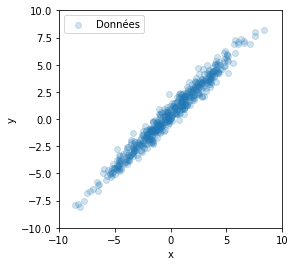

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(x, y, alpha=0.2, label="Données")

ax.set(xlim=(-10, 10), ylim=(-10, 10))
ax.set(xlabel="x", ylabel="y")

ax.legend()

En regardant cette figure, une relation linéaire entre $x_i$ et $y_i$ est assez évidente et notre modèle mathématique semble donc plausible.
La question à laquelle nous souhaiterons répondre est donc : comment calculer la meilleure estimation possible des paramètres $a$ et $b$ de notre modèle ?

### Formulation mathématique

Afin de répondre à cette question, il nous est d'abord nécessaire de définir une notion de l'erreur entre les prédictions $\hat{y}_i$ de notre modèle et nos observations expérimentales $y_i$.
Plusieurs définitions ont été proposées pendant la séance de cours.
La définition la plus commune est celle de l'[erreur quadratique moyenne](https://fr.wikipedia.org/wiki/Erreur_quadratique_moyenne).
Etant données les prédictions de notre modèle $\hat{y}_i = a x_i + b$ et les observations $y_i$, cette erreur est définie de la façon suivante

$$
\mathcal{L}(a, b) = \dfrac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

où $n$ est le nombre d'observations disponibles.
Cette notion de l'erreur faisant intervenir un carré, elle sera toujours positive.
De plus, si notre modèle prédit exactement les observations (i.e. $\hat{y}_i = y_i \quad \forall i$), alors cette erreur vaut 0.
Dans le cas contraire, elle sera supérieure à 0.
On cherche alors à trouver les valeurs de $a$ et $b$ de façon à minimiser cette erreur au maximum.

#### Comment minimiser une fonction ?

Lorsqu'une fonction (dérivable au moins une fois) atteint son minimum, le gradient de cette fonction est nul.
Minimiser une fonction revient donc à trouver les valeurs des paramètres de façon à ce que le gradient soit nul.
Une illustration a été donnée en cours.
Il nous est donc nécessaire de trouver une expression analytique du gradient de notre fonction objective.

Notre modèle étant donné par

$$
\hat{y}_i = a x_i + b,
$$

il est facile de montrer que la dérivée partielle de notre erreur quadratique moyenne $\mathcal{L}$ par rapport au coefficient directeur $a$ de la droite que l'on cherche à calculer est donnée par

$$
\dfrac{\partial \mathcal{L}}{\partial a} = -\dfrac{2}{n} \sum_{i=1}^n \left( y_i - a x_i - b \right) x_i.
$$

De la même façon, la dérivée partielle de $\mathcal{L}$ par rapport à $b$ est donnée par

$$
\dfrac{\partial \mathcal{L}}{\partial b} = -\dfrac{2}{n} \sum_{i=1}^n \left( y_i - ax_i - b \right).
$$

A partir d'une estimation initiale des paramètres $a$ et $b$, le gradient de $\mathcal{L}$ indique la direction dans laquelle notre erreur augmente.
Ainsi, si $\partial_a \mathcal{L} > 0$, augmenter légèrement la valeur de $a$ aura tendance à augmenter l'erreur de notre modèle (et similairement pour $b$).
Afin de minimiser notre fonction, il sera alors nécessaire de diminuer légèrement la valeur de $a$.
De même, si $\partial_a \mathcal{L} < 0$, diminuer légèrement la valeur de $a$ aura tendance à augmenter l'erreur de notre modèle.
Afin de minimiser notre fonction, il sera alors cette fois ci nécessaire d'augmenter légèrement la valeur de $a$.
Les mêmes principes s'appliquent pour $b$.

A partir de ce constat, il est alors facile de se convaincre que, étant donnée une estimation initiale des paramètres $a_0$ et $b_0$ du modèle, l'algorithme suivant devrait petit à petit converger vers un minimum de la fonction:

1. Calcul de $\mathcal{L}(a_k, b_k)$ et du gradient $\nabla \mathcal{L}$.
Si la norme du gradient est suffisament petite, alors on s'arrête car l'on est déjà très proche du minimum.
Sinon, on passe à l'étape 2.
2. Mise à jour des paramètres par la règle suivante
$$
\begin{aligned}
a_{k+1} & = a_k - \eta \dfrac{\partial \mathcal{L}}{\partial a} \\
b_{k+1} & = b_k - \eta \dfrac{\partial \mathcal{L}}{\partial b}
\end{aligned}
$$
où $\eta$ est le *pas de descente*.
En pratique $\eta$ ne doit pas être trop grand.
3. On retourne ensuite à la première étape.

Cet algorithme, connu sous le nom de **descente de gradient**, forme aujourd'hui la base de la plupart des méthodes d'optimisation, notamment celles utilisées en Machine Learning et Deep Learning.

### Illustration

Les cellules ci-dessous illustrent comment il vous est possible d'implémenter un tel algorithme en `python`.
Prenez le temps de bien lire les commentaires et de comparer les expressions avec celles données au dessous afin de bien comprendre ce que fait ce code.
Votre objectif sera de ré-écrire ce même code mais de façon plus efficace en utilisant au maximum les fonctions déjà présentes dans **NumPy**.

In [4]:
def objectif(x, y, a, b):
    """
    Fonction calculant la valeur de la fonction objective
    pour les paramètres courants a et b.
    
    INPUT
    -----
    
    x : Numpy array, shape (n,)
        Abscise des points de données.
        
    y : Numpy array, shape (n,)
        Ordonnée des points de données.
        
    a : float
        Cofficient directeur de la droite y = ax + b.
        
    b : float
        Constante de la droite y = ax + b.
        
    RETURN
    ------
    
    mse : float
          Erreur quadratique moyenne calculée à partir
          des coefficients a et b du modèle.
    """
    
    # --> Nombre de points de données.
    n = len(x)
    
    # --> Calcul de l'erreur quadratique moyenne.
    mse = 0.0
    
    for i in range(n):
        mse = mse + (y[i] - (a*x[i] + b))**2
        
    mse = mse / n

    return mse

La fonction ci-dessus calcule l'erreur quadratique moyenne de notre modèle (paramètres actuels $a$ et $b$) vis à vis de nos données.
La cellule ci-dessous illustre comment tester le temps d'exécution de cette fonction.

In [5]:
%%timeit
objectif(x, y, 2, 2)

530 µs ± 120 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Sur mon ordinateur, cette fonction prends de l'ordre de 500 microsecondes pour s'exécuter.
Plus tard dans le TP, il vous sera demander de la ré-écrire de façon plus optimisée.
En utilisant intelligement la fonction `np.mean` par exemple, il vous sera possible d'augmenter la rapidité d'exécution d'un facteur presque 30 (i.e. 15 microsecondes au lieu de 500). 

In [6]:
def gradient(x, y, a, b):
    """
    Fonction calculant le gradient de la fonction objective
    (i.e. les dérivées partielles par rapport à a et b).
    
    INPUT
    -----
    
    x : Numpy array, shape (n,)
        Abscise des points de données.
        
    y : Numpy array, shape (n,)
        Ordonnée des points de données.
        
    a : float
        Cofficient directeur de la droite y = ax + b.
        
    b : float
        Constante de la droite y = ax + b.
        
    RETURN
    ------
    
    da : float
         Composante du gradient par rapport à la variable a.
         
    db : float
         Composante du gradient par rapport à la variable b.
    """
    
    # --> Nombre de points.
    n = len(x)
    
    # --> Calcul de la composante du gradient associée
    #     au paramètre a (coefficient directeur).
    da = 0.0
    for i in range(n):
        da = da - (2/n) * (y[i] - a*x[i] - b) * x[i]

    # --> Calcul de la composante du gradient associée
    #     au paramètre b (constante).
    db = 0.0
    for i in range(n):
        db = db - (2/n) * (y[i] - a*x[i] - b)

    return da, db

In [7]:
%%timeit
gradient(x, y, 2, 2)

1.13 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
# Pour afficher le caractère η dans Jupyter : \eta<TABULATION>

def optimisation(x, y, η=0.01, tol=1e-8, maxiter=1000, verbose=True):
    """
    Boucle d'optimisation pour estimer les paramètres a et b de notre modèle
    à partir des données.

    INPUT
    -----
    
    x : Numpy array, shape (n,)
        Abscise des points de données.
        
    y : Numpy array, shape (n,)
        Ordonnée des points de données.
        
    η : flat (optionel)
        Pas d'optimisation.
        
    tol : flat (optionel)
          Tolérance pour arrêter le calcul.
          
    maxiter : int (optionel)
              Nombre maximum d'itérations possible avant d'arrêter le calcul.
              
    verbose : boolean (optionel)
              Contrôle l'affichage à l'écran des informations au cours du calcul.
    
    RETURN
    ------
    
    a : float
        Estimation du coefficient directeur de la droite.
        
    b : float
        Estimation de la constante du modèle.
    """
    
    # --> Estimation initiale des paramètres.
    a, b = 0.0, 0.0
    
    # --> Descente de gradient.
    for i in range(maxiter):
        # --> Calcul de la fonction objective.
        erreur = objectif(x, y, a, b)
        
        # --> Calcul du gradient.
        da, db = gradient(x, y, a, b)
        
        # --> Norme du gradient.
        residu = da**2 + db**2
        
        # --> Affichage à l'écran.
        if verbose:
            print("Itération {0} :".format(i))
            print("     - Fonction objective : {0}".format(erreur))
            print("     - Norme du gradient : {0}".format(residu))
            print()
        
        # --> Test si la norme du gradient est suffisament petite.
        if residu < tol:
            break
            
        # --> Mise à jour des paramètres.
        a = a - η*da
        b = b - η*db
    
    # --> Affiche les coefficients obtenus à la fin.
    if verbose:
        print("\n-------------------------------------\n\n")
        print("Estimation du coefficient directeur : {0}".format(a))
        print("Estimation de la constante : {0}".format(b))
    
    return a, b

In [9]:
a, b = optimisation(x, y, verbose=True)

Itération 0 :
     - Fonction objective : 9.947771784619572
     - Norme du gradient : 363.59839924391673

Itération 1 :
     - Fonction objective : 6.661316443940576
     - Norme du gradient : 237.25794676843358

Itération 2 :
     - Fonction objective : 4.516538119227279
     - Norme du gradient : 154.91595468870915

Itération 3 :
     - Fonction objective : 3.1158551275937465
     - Norme du gradient : 101.24591261004198

Itération 4 :
     - Fonction objective : 2.200179740774782
     - Norme du gradient : 66.2603314785631

Itération 5 :
     - Fonction objective : 1.6006735489758026
     - Norme du gradient : 43.45087843614633

Itération 6 :
     - Fonction objective : 1.2073089972175577
     - Norme du gradient : 28.57640188325629

Itération 7 :
     - Fonction objective : 0.9483826081279424
     - Norme du gradient : 18.873152031811046

Itération 8 :
     - Fonction objective : 0.7771648349010899
     - Norme du gradient : 12.540123739343334

Itération 9 :
     - Fonction object

Itération 151 :
     - Fonction objective : 0.2838192613420861
     - Norme du gradient : 0.0023506853978178628

Itération 152 :
     - Fonction objective : 0.2837959891063424
     - Norme du gradient : 0.002257774779232165

Itération 153 :
     - Fonction objective : 0.2837736367035207
     - Norme du gradient : 0.0021685364440808988

Itération 154 :
     - Fonction objective : 0.28375216777731166
     - Norme du gradient : 0.0020828252457077492

Itération 155 :
     - Fonction objective : 0.2837315474083864
     - Norme du gradient : 0.002000501774364327

Itération 156 :
     - Fonction objective : 0.2837117420575971
     - Norme du gradient : 0.0019214321304593925

Itération 157 :
     - Fonction objective : 0.2836927195114297
     - Norme du gradient : 0.0018454877067703905

Itération 158 :
     - Fonction objective : 0.2836744488296044
     - Norme du gradient : 0.001772544979263125

Itération 159 :
     - Fonction objective : 0.2836569002947547
     - Norme du gradient : 0.001702

Itération 277 :
     - Fonction objective : 0.283234119842313
     - Norme du gradient : 1.460306767217641e-05

Itération 278 :
     - Fonction objective : 0.2832339752691457
     - Norme du gradient : 1.4025882800082651e-05

Itération 279 :
     - Fonction objective : 0.2832338364102192
     - Norme du gradient : 1.3471511105608015e-05

Itération 280 :
     - Fonction objective : 0.2832337030396789
     - Norme du gradient : 1.2939050900058412e-05

Itération 281 :
     - Fonction objective : 0.28323357494059614
     - Norme du gradient : 1.2427636133899945e-05

Itération 282 :
     - Fonction objective : 0.28323345190461763
     - Norme du gradient : 1.1936434988128034e-05

Itération 283 :
     - Fonction objective : 0.283233333731625
     - Norme du gradient : 1.146464852130176e-05

Itération 284 :
     - Fonction objective : 0.28323322022940817
     - Norme du gradient : 1.1011509370069783e-05

Itération 285 :
     - Fonction objective : 0.2832331112133559
     - Norme du gradient :

     - Fonction objective : 0.2832304648593357
     - Norme du gradient : 1.1142208830221927e-08

Itération 456 :
     - Fonction objective : 0.2832304647490259
     - Norme du gradient : 1.0701814077364526e-08

Itération 457 :
     - Fonction objective : 0.2832304646430758
     - Norme du gradient : 1.0278825885568059e-08

Itération 458 :
     - Fonction objective : 0.28323046454131356
     - Norme du gradient : 9.872556262135089e-09


-------------------------------------


Estimation du coefficient directeur : 0.9953296234175988
Estimation de la constante : 0.49533532060600916


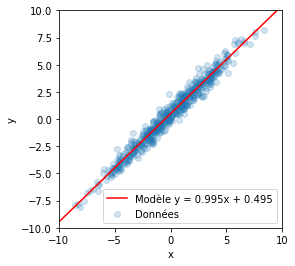

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.scatter(x, y, alpha=0.2, label="Données")

z = np.linspace(-10, 10)
ax.plot(z, a*z + b, color="red", label="Modèle y = {0:0.3f}x + {1:0.3f}".format(a, b))


ax.set(xlim=(-10, 10), ylim=(-10, 10))
ax.set(xlabel="x", ylabel="y")

ax.legend()

In [11]:
%%timeit
optimisation(x, y, verbose=False)

407 ms ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

## TP

C'est maintenant à vous de jouer.
En utilisant les différentes fonctions **NumPy** vues notamment au cours du TP n°2, votre objectif est d'augmenter la rapidité d'exécution de chacune de ces fonctions.
L'essentiel de votre travail devra se concentrer sur les fonctions `objectif` et `gradient` car c'est là que votre calcul passera la majeure partie de son temps.
Pensez à ajouter en commentaire à chaque fois pourquoi vous pensez que les modifications que vous avez effectuées améliorent les performances du code.
Pensez également à vérifier que ces mêmes modifications ne changent pas pour autant le résultat (i.e. que ce vous codez est effectivement correcte!).